# K Nearest P Median Problem and Implementation

## Introduction

The P-Median Model with Near-Far Cost Allocation, alternatively known as the k nearest p-median Problem, offers a distinctive twist on the traditional p-median problem. This approach enhances our capability to effectively address location allocation challenges. In this notebook, we'll dive into the problem's formulation, and showcase the implementation of the `KNearestPMedian` class in the `spopt` package.

This newly developed model is a contribution to the `spopt` as part of the [Google Summer of Code 2023](https://summerofcode.withgoogle.com/).

### Understanding the K Nearest P-median Problem

The k nearest p-median problem extends the concept of facility location allocation by considering both nearest and non-nearest facilities. In the article by Church (2018), it proposed this new p-median model which can distinguish between near and far facilities, use both explicit and implicit variables for capacity allocations. By integrating this model, the `spopt` package becomes equipped to deliver heightened precision and efficiency in solving spatial optimization problems, especially those involving extensive datasets and substantial demand volumes.

The model can be formulated as:

$\begin{array}
       \displaystyle \textbf{Minimize} & \displaystyle \sum_{i \in I}\sum_{k \in k_{i}}{a_i d_{ik} X_{ik}} + \sum_{i \in I}{g_i (d_{i{k_i}} + 1)}  &&& (1) \\
       \displaystyle \textbf{Subject To} & \sum_{k \in k_{i}}{X_{ik} + g_i = 1} && \forall i \in I & (2) \\
                                            & \sum_{j \in J}{Y_j} = p                                                                                   &&                                          & (3)                                                                               \\
                                            & \sum_{i \in I}{a_i X_{ik}} \leq {Y_{k} c_{k}}                                                             &&  \forall k \in k_{i}                     & (4)                                                                               \\  
                                            & X_{ij} \leq Y_{j}                                                                                         && \forall i \in I \quad \forall j \in J    & (5)                                                                               \\
                                            & X_{ij} \in \{0, 1\}                                                                                       && \forall i \in I \quad \forall j \in J    & (6)                                                                               \\
                                            & Y_j \in \{0, 1\}                                                                                          && \forall j \in J                          & (7)                                                                               \\
                                            &                                                                                                           &&                                          &                                                                                   \\ \end{array}$
                                            
$\begin{array} \displaystyle \textbf{Where}&& i& =& \textrm{index of demand points/areas/objects in set } I\\
                                            && j                                                                                                        & =                                         & \textrm{index of potential facility sites in set } J                              \\
                                            && p                                                                                                        & =                                         & \textrm{the number of facilities to be sited}                                     \\
                                            && a_i                                                                                                      & =                                         & \textrm{service load or population demand at client location } i                  \\
                                            && k_{i}                                                                                                    & =                                         & \textrm{the } k \textrm{ nearest facilities of client location } i                        \\
                                            && c_{j}                                                                                                    & =                                         & \textrm{the capacity of facility} j                                               \\   
                                            && d_{ij}                                                                                                   & =                                         & \textrm{shortest distance or travel time between locations } i \textrm{ and } j   \\
                                            && X_{ij}                                                                                                   & =                                         & \begin{cases}
                                                                                                                                                                                                       1, \textrm{if client location } i \textrm{ is served by facility } j             \\
                                                                                                                                                                                                       0, \textrm{otherwise}                                                            \\
                                                                                                                                                                                                      \end{cases}                                                                       \\
                                            && Y_j                                                                                                      & =                                         & \begin{cases}
                                                                                                                                                                                                       1, \textrm{if a facility is sited at location } j                                \\
                                                                                                                                                                                                       0, \textrm{otherwise}                                                            \\
                                                                                                                                                                                                      \end{cases}                                                                       \\ 
                                            && g_i                                                                                                      & =                                         & \begin{cases}
                                                                                                                                                                                                       1, \textrm{if the client } i \textrm{ need to be served by non-k-nearest facilities}     \\
                                                                                                                                                                                                       0, \textrm{otherwise}                                                            \\
                                                                                                                                                                                                      \end{cases}                                                                       \\ \end{array}$

This model introduces a clever approach by differentiating between nearby and distant facilities. For instance, at the beginning, only the five closest facilities to each client are considered, which are termed as "near" facilities. If all client demands and constraints can be satisfied, the problem will have an optimal solution right away. However, if the initial facilities can't meet all the demands, we can supplement them with additional nearby facilities.

Mathematically, we create a variable called the **placeholder facility decision variable**, which is $g_i$
in the formula, presenting the distant facilities.

In terms of the **solution approach**:
1. For each client, identify their five closest facilities.
2. Run the p-median model only for the selected facilities from Step 1 (referred to as "explicitly assigned" in the paper).
3. Check the model outcome. If all $g_i$ values for clients are equal to 0 and an optimal solution exists, we accept this solution.
4. If some $g_i$ values are more than 0, we need to increase the value $k$ for specific clients. Then, rerun the model. Ensure that all $g_i$ values become 0, indicating an optimal solution.

The default starting value for $k$ is 5, or the total number of facilities if it is fewer than 5. Nevertheless, users have the flexibility to customize this value according to their particular requirements.

This model allows us to avoid incorporating the complete set of distances and facilities into the model. Instead, we can focus on integrating smaller segments of these elements and utilize iteration to identify the optimal solution, thereby enhancing computational speed and efficiency.

## The `KNearestPMedian` Class Implementation

We opt to generate a fresh subclass named `KNearestPMedian` within the `spopt` library, derived from the `PMedian` class. This new subclass can inherit all the modules employed by its parent class.

Following this, we will proceed to outline its benefits and features, encompassing two key aspects: 
1. enhanced efficiency and performance with tree query and sparse matrices,
2. structural composition and logical framework.

### Enhanced Efficiency

The `KNearestPMedian` class exclusively allows the use of **geodataframes** as input data. This approach eliminates the need for users to manually compute distances. A significant enhancement is the utilization of an appropriate **tree data structure**, enabling efficient retrieval of the k nearest facilities for each client. This method significantly reduces computation time by avoiding the calculation and comparison of all distances. Additionally, the resultant distances will be stored in a format of a **sparse matrix**, optimizing memory utilization, particularly for extensive datasets.

### Structure and Logics

The class works with weighted service loads of clients and facilitates, offering flexibility in assigning the number of nearest facilities for each client. Optional capacity constraints and various distance metrics can be applied. The class offers methods to initialize attributes, add objective functions, create sparse matrices for distances, dynamically update k values, and solve the model iteratively. It provides insights into facility-to-client relationships and related attributes.

The `KNearestPMedian` class and its methods are as following:

| Aspect               | Description                                                                                                                                                                              |
|----------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Class Definition** |                                                                                                                                                                                          |
| Class Name           | `KNearestPMedian` (subclass of `PMedian`)                                                                                                                                                |
| Description          | Implements the P-Median Model with Near-Far Cost Allocation and solves it.                                                                                                             |
|                      | Adapted from a specific citation and formulation.                                                                                                                                      |
| **Parameters**       |                                                                                                                                                                                          |
| `ai_sum`        | Sum of weights representing the service loads of clients.                                                                                                                               |
| `clients`            | An array of coordinates of clients.                                                                                                                                                     |
| `facilities`         | An array of coordinates of facilities.                                                                                                                                                  |
| `weights`            | An array of weights representing the service loads of clients.                                                                                                                          |
| `k_array`            | An array of k values representing the number of nearest facilities for each client.                                                                                                    |
| `p_facilities`       | The number of facilities to be located.                                                                                                                                                 |
| `capacities`         | An array of facility capacities (optional).                                                                                                                                             |
| `distance_metric`    | The distance metric used for computing distances between clients and facilities.                                                                                                        |
| `name`               | The problem name.                                                                                                                                                                       |
| **Methods**          |                                                                                                                                                                                          |
| `__init__`           | Constructor method to initialize class attributes and parameters.                                                                                                                      |
| `__add_obj`          | Method to add the objective function to the model.                                                                                                                                     |
| `from_cost_matrix`   | Static method (not supported in this subclass).                                                                                                                                         |
| `_create_sparse_matrix` | Method to create a sparse matrix representing the distances between clients and their k nearest facilities.                                                                           |
| `_update_k_array`    | Method to increase the k value for clients with `g_i` > 0 and update the k array.                                                                                                     |
| `_from_sparse_matrix` | Method to create the problem from the sparse distance matrix.                                                                                                                           |
| `from_geodataframe`  | Class method to create an instance from geodataframes.                                                                                                                                  |
| `facility_client_array` | Method to create a 2D array storing facility to client relationships.                                                                                                                   |
| `solve`              | Method to solve the k nearest p-median model iteratively.                                                                                                                              |
| **Attributes**       |                                                                                                                                                                                          |
| `sparse_matrix`      | Compressed Sparse Row matrix representing the distance matrix between clients and facilities.                                                                                          |
| `aij`                | Compressed Sparse Row matrix storing the weighted cost matrix between clients and facilities.                                                                                          |
| `problem`            | A `pulp` instance of an optimization model with constraints, variables, and an objective function.                                                                                     |
| `fac2cli`            | A 2D array storing facility to client relationships.                                                                                                                                   |
| `cli2fac`            | Inverse of `fac2cli` showing client to facility relationships.                                                                                                                          |

**Iterative Solution Approach**:

The `solve()` method implements an iterative approach to solving the problem.
It repeatedly constructs sparse matrices and creates the problem based on the calculated distances.
The goal is to iteratively allocate clients to their nearest facilities and dynamically adjust k values for unallocated clients.
This iterative process continues until no more clients need to be assigned to placeholder facilities.

The logic of `solve()` is as following:

![Flowchart](../flowchart/solve().png)

## Use the New Model

In this part, we will introduce how to prepare the data and use the function with simple sample data.

In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pulp
import matplotlib.pyplot as plt
from spopt.locate.p_median import KNearestPMedian

The accepted input format is a geodataframe. It's crucial that the coordinate reference system (CRS) of the demand points geodataframe matches that of the facilities points geodataframe. Otherwise, the module will generate an error due to CRS mismatch.

In [4]:
# Sample demand points data
sample_client = np.array(
    [[10.5, 1], [11.5, 1], [13.5, 1], [14.5, 1], [16.5, 1], [17.5, 1]]
)
demand_data = {
    "DemandID": [i + 1 for i in range(len(sample_client))],
    "geometry": [Point(x, y) for x, y in sample_client],
    "demand": [1] * len(sample_client),
}
dem = gpd.GeoDataFrame(demand_data, crs="EPSG:4326")

# Sample facility points data
sample_facility = np.array(
    [[11, 1], [10, 2], [12, 0], [14, 1], [13, 2], [15, 0], [17, 1], [16, 2], [18, 0]]
)
facility_data = {
    "FacilityID": [i + 101 for i in range(len(sample_facility))],
    "geometry": [Point(x, y) for x, y in sample_facility],
    "capacity": [1] * len(sample_facility),
}
fac = gpd.GeoDataFrame(facility_data, crs="EPSG:4326")

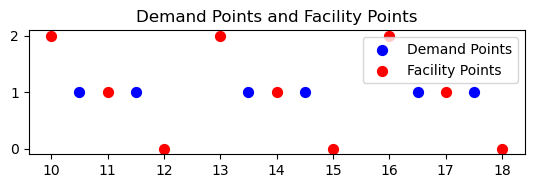

In [5]:
# Create a plot
fig, ax = plt.subplots()

# Plot demand points and facility points
dem.plot(ax=ax, color="blue", markersize=50, label="Demand Points")
fac.plot(ax=ax, color="red", markersize=50, label="Facility Points")

# Set plot title and legend
ax.set_title("Demand Points and Facility Points")
ax.legend()

# Show the plot
plt.show()

Examining this uncomplicated dataset reveals that two demand points share the closest facility. However, each facility has a capacity to serve only one client. Consequently, one of the points must be assigned to its second nearest facility.

To demonstrate the effectiveness of the new model in this scenario, we can initialize the k values at 1 for all clients. It's important to note that the k values should be created as a numpy array.

In [11]:
intial_k = np.ones(6, dtype=int)
prob = KNearestPMedian.from_geodataframe(
    dem,
    fac,
    "geometry",
    "geometry",
    "demand",
    6,
    facility_capacity_col="capacity",
    k_array=intial_k
)

In [12]:
prob = prob.solve(pulp.PULP_CBC_CMD(msg=False))

Now we can look at the model results.

In [14]:
for i in range(len(dem)):
    for j in range(len(fac)):
        if (i, j) in prob.cli_assgn_vars and prob.cli_assgn_vars[(i, j)].value() == 1:
            print(f"Client {i} is served by Facility {j}")

Client 0 is served by Facility 1
Client 1 is served by Facility 0
Client 2 is served by Facility 4
Client 3 is served by Facility 3
Client 4 is served by Facility 7
Client 5 is served by Facility 6


The outcome aligns with our anticipations. Furthermore, we can retrieve additional parameters using the code provided below:

In [15]:
prob.fac2cli

[[1], [0], [], [3], [2], [], [5], [4], []]

In [16]:
prob.mean_dist

0.8090169943749475

By utilizing the `k_array`, we can extract the k values from the last iteration. In this example, due to the presence of capacity constraints, specific clients have had their k values augmented to 2, even though our initial input for k was uniform and set to 1.

In [17]:
prob.k_array

array([2, 1, 2, 1, 2, 1])

You also have the option to obtain the complete sparse distance matrix from the most recent iteration. You can achieve this by using `sparse_matrix` to retrieve the distance without weights, and by using `aij` to obtain the distance with weights incorporated.

In [19]:
print(prob.sparse_matrix.toarray())

[[0.5        1.11803399 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.5        0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.5        1.11803399 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        1.11803399 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.         0.        ]]


### References:

- [Church, R. L. (2018). Tobler’s Law and Spatial Optimization: Why Bakersfield? International Regional Science Review, 41(3), 287–310.](https://doi.org/10.1177/0160017616650612) 